In [56]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numba
import scipy.ndimage as nd
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
import sys, os, glob, csv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon

def getFrameFile(folder, frameNum):
    if folder[-1] != '/': folder += '/'
    files = sorted(glob.glob(folder+"*.h5"))
    if len(files) == 0:
        raise ValueError("No files found in "+folder)
    if len(files) <= frameNum:
        raise ValueError("You don't have "+str(frameNum)+" files in "+folder)
    return files[frameNum]
    if frameNum == -1:
        files = sorted(glob.glob(folder+"*.h5"))
        if len(files) == 0:
            raise ValueError("No files found in "+folder)
        return files[-1]
    else:
        matchString = folder+"*{:06d}.h5".format(frameNum)
        files = glob.glob(matchString)
        if len(files) != 1:
            raise ValueError("Could not find exactly one file matching "+matchString)
        return files[0]

def get3D(froot,diag,frame,mult=1,xlim=[],ylim=[],zlim=[],smooth=0):
    if froot[-1] != '/': froot += '/'
    d = h5py.File(sorted(glob.glob(froot+'*.h5'))[frame],'r')
    value = d[diag][:].T*mult
    x0,x1 = d['AXIS']['AXIS1']
    y0,y1 = d['AXIS']['AXIS2']
    z0,z1 = d['AXIS']['AXIS3']
    nx, ny, nz = value.shape
    x, y, z = np.linspace(x0,x1,nx),np.linspace(y0,y1,ny),np.linspace(z0,z1,nz)
    t = d.attrs['TIME'][0]    
    if len(xlim)==2:
        xi0 = int(len(x)*(xlim[0]-x0)/(x1-x0))
        xi1 = int(len(x)*(xlim[1]-x0)/(x1-x0))
        x0, x1 = x[xi0], x[xi1]
        nx = xi1-xi0
        value = value[xi0:xi1,:,:]
        x = np.linspace(x0,x1,nx)
    if len(ylim)==2:
        yi0 = int(len(y)*(ylim[0]-y0)/(y1-y0))
        yi1 = int(len(y)*(ylim[1]-y0)/(y1-y0))
        y0, y1 = y[yi0], y[yi1]
        ny = yi1-yi0
        value = value[:,yi0:yi1,:]
        y = np.linspace(y0,y1,ny)
    if len(zlim)==2:
        zi0 = int(len(z)*(zlim[0]-z0)/(z1-z0))
        zi1 = int(len(z)*(zlim[1]-z0)/(z1-z0))
        z0, z1 = z[zi0], z[zi1]
        nz = zi1-zi0
        value = value[:,:,zi0:zi1]
        z = np.linspace(z0,z1,nz)
    if smooth != 0: value = nd.gaussian_filter(value,smooth)
    return value,x,y,z,t


In [63]:
def nearest(num_in,mult): 
    return mult*np.sign(num_in)*int(np.abs(num_in)/mult)
@numba.njit()
def cross(v1,v2):
    return np.array([v1[1]*v2[2]-v1[2]*v2[1], -v1[0]*v2[2]+v1[2]*v2[0], v1[0]*v2[1]-v1[1]*v2[0]])
@numba.njit()
def norm(v):
    return v/np.sqrt(np.sum(v**2))
@numba.njit()
def mag(v):
    return np.sqrt(np.sum(v**2))
@numba.njit()
def jet(x):
    # Approximate RGB values for jet colormap from matplotlib
    return np.array([max(0,min(1,1.5*(1-2.6*abs(x-.76)))),
                     max(0,min(1,1.5*(1-2.6*abs(x-.5)))),
                     max(0,min(1,1.5*(1-2.6*abs(x-.24))))])
@numba.njit()
def clip(a,a0,a1):
    return max(a0,min(a1,a))

@numba.njit()
def box_intersect(box0,box1,r,n):
    # Check where a ray at position r, direction n will intersect box described by extent box0, box1.
    x0,y0,z0 = box0
    x1,y1,z1 = box1
    s0 = (x0-r[0])/(n[0]+1e-9)
    s1 = (x1-r[0])/(n[0]+1e-9)
    s2 = (y0-r[1])/(n[1]+1e-9)
    s3 = (y1-r[1])/(n[1]+1e-9)
    s4 = (z0-r[2])/(n[2]+1e-9)
    s5 = (z1-r[2])/(n[2]+1e-9)

    smin = max(min(s0, s1), min(s2, s3), min(s4, s5))
    smax = min(max(s0, s1), max(s2, s3), max(s4, s5))

    collide = (smax<0) + (smin>smax) == 0
    return np.array([collide, smin,smax])


@numba.njit()
def point3dToScreen(rpoint,rcamera,ncamera,dcamera,fov,pixels):
    # Project 3D point (rpoint) onto camera plane described by rcamera,ncamera,dcamera,fov (see pathtrace for more info)
    # Returns position on camera plane in pixels.
    
    dpoint = rpoint-rcamera
    npoint = dpoint/np.sqrt(np.sum(dpoint**2))
    costheta = np.sum(ncamera*npoint)
    dpixel = dcamera/costheta
    dcamplane = dpixel*npoint - dcamera*ncamera
    
    wcamera = cross(ncamera,zhat)
    wcamera /= mag(wcamera)
    hcamera = -cross(ncamera,wcamera)
    hcamera /= mag(hcamera)
    
    
    return np.sum(dcamplane*wcamera)/fov[0]*pixels[0]+pixels[0]/2, np.sum(dcamplane*hcamera)/fov[1]*pixels[1]+pixels[1]/2

xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])

@numba.njit(parallel=True)
def pathtrace(rho,bounds,rcamera,ncamera,dcamera,fov,pixels,dr,opacity_scale_func,cmap_func,vlim,
               screen_r,screen_g,screen_b,screen_a):
    '''
    Path tracing/volumetric ray casting algorithm to visualize 3D volumetric data
    Ballistically propagates rays from camera into 3D volume to produce 2D image.
    Currently does not support reflection or refraction of any kind. 
    The volume will glow with the colormap of choice. Other light sources and global 
    illumination are not supported.
    
    Author: John Ryan Peterson, jrpete@stanford.edu
    
    Parameters:
        Required inputs:
            rho: 3D array of floats; volumetric data for imaging
            bounds: 6-tuple of ints; bounds of rho in order [x min, x max, y min, y max, z min, z max]
            rcamera: 3-tuple of floats; the x,y,z coordinates of camera origin
            ncamera: 3-tuple of floats; a unit vector containing the camera pointing direction
            dcamera: float; distance of camera plane from camera origin
            fov: 2-tuple of floats; width,height of camera plane
            pixels: 2-tuple of ints; number of pixels to render
            dr: float; ray marching step size
            opacity_scale_func (r,value): function which has the following properties:
                Inputs: 
                    r: 3-tuple of floats; the x,y,z position of the ray.
                            By making this very large only at cetain x,y, or z positions, you can add
                            opaque slices to your rendered volume.
                    value: float; the normalized density at this location. This allows you to use 
                            a variety of opacity functions, not just linearly scaling with the value.
                Outputs:
                    opacity: float; the normalized opacity. The ray color will saturate at a distance 1/opacity.
            vlim: 2-tuple of floats; the minimum and maximum permitted values of rho.
            cmap_func: function  naming a matplotlib colormap function; the colormap for the volumetric rendering.
            
        Required inputs for data output.
            screen_r: 2D array of floats with size equal to pixels; the output array for the red channel
            screen_g: 2D array of floats with size equal to pixels; the output array for the green channel
            screen_b: 2D array of floats with size equal to pixels; the output array for the blue channel
            screen_a: 2D array of floats with size equal to pixels; the output array for the alpha channel
            
        Outputs:
            None 
    '''
    
    # Make sure data is numpy arrays
#     rho = np.array(rho)
#     rcamera = np.array(rcamera)
#     ncamera = np.array(ncamera)
    
    # Calculate the cell size
    x0,x1,y0,y1,z0,z1 = bounds
    box0,box1 = np.array([x0,y0,z0]),np.array([x1,y1,z1])
    nx,ny,nz = rho.shape
    Dx,Dy,Dz = x1-x0,y1-y0,z1-z0
    dx,dy,dz = Dx/(nx+1),Dy/(ny+1),Dz/(nz+1)
    
    # Get basis vector for camera plane
    wcamera = cross(ncamera,zhat)
    wcamera /= mag(wcamera)
    hcamera = -cross(ncamera,wcamera)
    hcamera /= mag(hcamera)
    if hcamera[2]<0:
        hcamera *= -1

    # Iterate over pixels in camera plane
    for i in numba.prange(pixels[0]): # Rows of pixels; Numba will parallelize over this axis
        for j in range(pixels[1]): # Columns of pixels
            
            # Pixel count from center of camera plane
            camplane_w = (i-pixels[0]/2)/pixels[0]*fov[0]
            camplane_h = (j-pixels[1]/2)/pixels[1]*fov[1]
            #print(camplane_w,camplane_h)
            # Get the ray starting position in the camera plane
            r = rcamera + ncamera*dcamera + wcamera*camplane_w + hcamera*camplane_h
            n = norm(r-rcamera) # Ray direction
            
            # We start with no color, but accumulate color as we propagate through the volume
            color = np.array([0.,0.,0.]) 
            lightlevel_start = 1
            lightlevel = lightlevel_start
            lightlevelmin = 1e-2 # Stop propagating the ray when we've reached 99% opacity.
            
            # Check if the ray is even going to intersct the rendering volume
            collide, smin, smax = box_intersect(box0,box1,r,n)
            s = 0
            
            if not collide: # No collision
                r += smax*n
                s += smax
            else: # Ray will hit the box
                r += smin*n
                s += smin
            
            # Propagate until the ray leaves the farthest surface of the box
            while s<smax:
                r += n*dr
                s += dr
                
                # Get cell indices and position within each cell
                px,py,pz = (r[0]-x0)/dx, (r[1]-y0)/dy, (r[2]-z0)/dz
                ix,iy,iz = int(px),int(py),int(pz)
                fx,fy,fz = px-ix,py-iy,pz-iz
                
                # Linearly interpolate data
                if ix>-1 and ix<nx-1 and iy>-1 and iy<ny-1 and iz>-1 and iz<nz-1:
                    value = (fx    *fy    *fz     * rho[ix+1,iy+1,iz+1] + 
                             fx    *fy    *(1-fz) * rho[ix+1,iy+1,iz] + 
                             fx    *(1-fy)*fz     * rho[ix+1,iy,iz+1] + 
                             fx    *(1-fy)*(1-fz) * rho[ix+1,iy,iz] + 
                             (1-fx)*fy    *fz     * rho[ix,iy+1,iz+1] + 
                             (1-fx)*fy    *(1-fz) * rho[ix,iy+1,iz] + 
                             (1-fx)*(1-fy)*fz     * rho[ix,iy,iz+1] + 
                             (1-fx)*(1-fy)*(1-fz) * rho[ix,iy,iz])
#                     value = rho[ix,iy,iz]
                    vnorm = clip((value-vlim[0])/(vlim[1]-vlim[0]),0,1)
                    # Get the cmap color for this value
                    dcolor = cmap_func(vnorm) 
                    # optical depth can be spatially varying and nonlinear with respect to the value
                    optical_depth = opacity_scale_func(r,vnorm)*dr 
                    transmission = np.exp(-optical_depth)
                    
                    # Add the color to the pixel and lower the transmission accordingly
                    opacity = 1-transmission
                    color += dcolor*lightlevel*opacity
                    lightlevel *= transmission
                    if lightlevel<lightlevelmin: break # Quit if we've reached 99% opacity.
            if lightlevel<1:
                color /= (1-lightlevel)
            
            # Add the color to the output arrays.
            screen_r[i,j] = clip(color[0],0,1)
            screen_g[i,j] = clip(color[1],0,1)
            screen_b[i,j] = clip(color[2],0,1)
            screen_a[i,j] = clip(lightlevel/lightlevel_start,0,1)
    
    # We don't return anything since we load the output arrays during computation

In [65]:

def plotPathTrace(froots,diags,frame,rcamera,thcamera,pixels,dr,figsize,dpi,axesback=True,axesfront=True,image=True,
                   combineFunc=lambda v:v[0],mult=1,xlim=[],ylim=[],zlim=[],vlim=[],cmap='jet',vlabel='',xslices=np.array([1e10]),
                   yslices=np.array([1e10]),zslices=np.array([1e10]),opacity=1,dcamera=1,fov=(1.5,1),save='',show=True,lintrans=True,
                   scales=[1,1,1],offsets=[0,0,0],cbarloc='upper right'):
    
    '''
    Plots volumetric rendering with axes overlaid on top. This function performs several steps:
    
    1 - reads 3D HDF5 OSIRIS grid data (possibly from multiple files),
    2 - computes a single 3D density to plot by combining multiple 3D osiris outputs using 'combineFunc', 
    3 - computes spatially-dependent opacity function, allowing for opaque data slices within the dataset,
    4 - uses the function 'pathtrace' to render the image,
    5 - renders optional box boundaries, and scale ticks and labels
    6 - displays and saves the composite image
    
    Author: John Ryan Peterson, jrpete@stanford.edu
    
    Parameters:
        Required inputs:
            froots: tuple of strings; paths to the folders with the data which you wish to visualize;
                    for example, ['/home/user/data/osiris_run1/MS/FLD/b2-savg',
                                  '/home/user/data/osiris_run1/MS/FLD/b3-savg'] 
                                  (note, if length >1, you should specify combineFunc)
            diags: tuple of strings; the diagnostic strings for the data in your froots parameter;
                    for example, ['b2','b3']
            frame: int; specifies the frame number of your data in the froots parameter which you wish to plot
            rcamera: 3-tuple of floats; the x,y,z coordinates of camera origin
            thcamera: 2-tuple of floats; the camera pointing direction in degrees.
                                         The first angle is measured down from horizontal (z up).
                                         The second is measured from the x axis towards the y axis.
                                         For example, (0,0) is pointing in the x-direction.
            pixels: 2-tuple of ints; number of pixels to render
            dr: float; ray marching step size
            figsize: 2-tuple of floats; output image size in inches
            dpi: int; output image dots per inch
            
        Optional inputs:
            axesback: bool (True); specify whether to plot axes behind the image
            axesfront: bool (True); specify whether to plot the axes in front of the image
            image: bool (True); specify whether to plot the image (disable this to get a plot of just the axes)
            combineFunc: function (lambda v:v[0]); specify how to combine your different 3D datasets in the 
                         'froots' parameter
                    Inputs: N-tuple of 3D numpy arrays, where N is the length of 'froots'
                    Outputs: 3D numpy array (with the same size as each of the input arrays)
            mult: float (1); multiplies the input data by a constant; useful to invert the charge density or 
                             downscale its value
            xlim: tuple of floats ([]); you may set 2 optional reduced x-direction bounds to trim your data
            ylim: tuple of floats ([]); you may set 2 optional reduced y-direction bounds to trim your data
            zlim: tuple of floats ([]); you may set 2 optional reduced z-direction bounds to trim your data
            vlim: 2-tuple of floats([]); manually specify the output min and max image values
            cmap: string ('jet'); Colormap name for the 3D visualization
            xslices: tuple of floats ([1e10]); select x-positions of opaque planes in the data for visualization
            yslices: tuple of floats ([1e10]); select y-positions of opaque planes in the data for visualization
            zslices: tuple of ;loats ([1e10]); select z-positions of opaque planes in the data for visualization
            opacity: float (1); the opacity of the 3D data. Ray marching will saturate when opacity*distance~1.
            dcamera: float (1); the distance of the camera plane from the camera origin.
            fov: 2-tuple of floats (1.5,1); the spatial extent of the camera plane (width,height).
            save: string (''); set to a filename to save the resulting image.
            show: bool (True); whether to display the resulting image
            scales: 3-tuple of floats ([1,1,1]); scales the simulation data axes lengths by these factors (x,y,z)
            offsets: 3-tuple of floats ([0,0,0]); Shifts the simualtion data spatial position by this amount 
                                                  before applying optional rescaling.
            cbarloc: string ('upper right'); colorbar location (see matploblib documentation).
            
        Outputs:
            None 
    '''
    
    # Get simulation data
    values = []
    for froot,diag in zip(froots,diags):
        value,x,y,z,t = get3D(froot,diag,frame,xlim=xlim,ylim=ylim,zlim=zlim,mult=mult)
        values.append(value)
    value = combineFunc(values) # Combine possible multiple data files to a single 3D array for plotting
    # Shift the data position
    x = (x-offsets[0])#*scales[0]
    y = (y-offsets[1])#*scales[1]
    z = (z-offsets[2])#*scales[2]
    # Get the box size
    x0,x1 = x[0],x[-1]
    y0,y1 = y[0],y[-1]
    z0,z1 = z[0],z[-1]
    # Rescale the data
    x0s,x1s = x0*scales[0],x1*scales[0]
    y0s,y1s = y0*scales[1],y1*scales[1]
    z0s,z1s = z0*scales[2],z1*scales[2]
    bounds = x0s,x1s,y0s,y1s,z0s,z1s
    box0,box1 = np.array([bounds[0],bounds[2],bounds[4]]),np.array([bounds[1],bounds[3],bounds[5]])
    # If vlim is not specified, go from data min to max
    if len(vlim)==0: 
        vlim=[np.min(data),np.max(value)] 

    # Initialize output arrays for the three color channels and transparency
    red,green,blue,alpha = np.zeros(pixels),np.zeros(pixels),np.zeros(pixels),np.zeros(pixels)
    
    # Get camera normal!
    thcamera = np.array(thcamera)
    ncamera = np.empty(3).astype(float)
    # See here how the camera normal is calculated from the two camera angles
    ncamera[0] = np.cos(thcamera[0]*np.pi/180)*np.cos(thcamera[1]*np.pi/180)
    ncamera[1] = np.sin(thcamera[0]*np.pi/180)*np.cos(thcamera[1]*np.pi/180)
    ncamera[2] = -np.sin(thcamera[1]*np.pi/180)
    
    
    # Get the colormap! Numba only accepts certain functions, so we need to interpolate the matplotlib
    # colormaps to 1D arrays before using in our accelerated pathtrace function.
    xarr = np.linspace(0,1,101)
    cmap_mpl = cm.get_cmap(cmap,len(xarr))
    colors = np.array([cmap_mpl(xi) for xi in range(len(xarr))])
    mapred = colors[:,0]
    mapgreen = colors[:,1]
    mapblue = colors[:,2]
    @numba.njit()
    def cmap_func(x):
        return np.array([np.interp(x,xarr,mapred),np.interp(x,xarr,mapgreen),np.interp(x,xarr,mapblue)])
    
    # Opacity will be a constant value everywhere but it spikes at locations where we want to plot slices
    @numba.njit()
    def opacity_scale_func(r,valnorm): 
        return ((np.sum((np.abs(r[0]-xslices)<dr/2)*1e6)+
                np.sum((np.abs(r[1]-yslices)<dr/2)*1e6)+
                np.sum((np.abs(r[2]-zslices)<dr/2)*1e6)) + opacity)*(valnorm*lintrans+(1-lintrans))
    
    # Render the image!
    if image: pathtrace(value,bounds,rcamera,ncamera,dcamera,fov,pixels,dr,opacity_scale_func,cmap_func,vlim,
                        red,green,blue,alpha)
    
    
    # Show the image
    if show:
        plt.figure(figsize=figsize,dpi=dpi)

        # Plot grid marks
        corners = [x0,y0,z0],[x0,y0,z1],[x0,y1,z0],[x0,y1,z1],[x1,y0,z0],[x1,y0,z1],[x1,y1,z0],[x1,y1,z1]
        corners = [np.array(c) for c in corners]
        lines = [ # all twelve lines that make up the 3D box
            [[x0s,y0s,z0s],[x0s,y0s,z1s]],[[x0s,y0s,z0s],[x0s,y1s,z0s]],[[x0s,y0s,z0s],[x1s,y0s,z0s]],
            [[x0s,y1s,z1s],[x0s,y1s,z0s]],[[x0s,y1s,z1s],[x0s,y0s,z1s]],[[x0s,y1s,z1s],[x1s,y1s,z1s]],
            [[x1s,y1s,z0s],[x1s,y1s,z1s]],[[x1s,y1s,z0s],[x1s,y0s,z0s]],[[x1s,y1s,z0s],[x0s,y1s,z0s]],
            [[x1s,y0s,z1s],[x1s,y0s,z0s]],[[x1s,y0s,z1s],[x1s,y1s,z1s]],[[x1s,y0s,z1s],[x0s,y0s,z1s]],
        ]
        lines = np.array(lines)
        
        # Figure out which lines are in front of and behind the data so we display them in the correct order
        linesfront = []
        linesback = []
        for line in lines:
            r1,r2 = line
            p1 = point3dToScreen(r1,rcamera,ncamera,dcamera,fov,pixels)
            p2 = point3dToScreen(r2,rcamera,ncamera,dcamera,fov,pixels)
            r12 = (r1+r2)/2
            nmid = norm(r12-rcamera)
            collide,smin,smax = box_intersect(box0,box1,rcamera,nmid)
            front = np.abs(smin-mag(r12-rcamera))<np.max(np.abs(lines))/1e6
            #print(r12,collide,smin,smax)
            if front: linesfront.append([line,p1,p2])
            else: linesback.append([line,p1,p2])
        
        # Plot the lines behind the data
        if axesback: 
            for line,p1,p2 in linesback:
                plt.plot([p1[0],p2[0]],[p1[1],p2[1]],'k',lw=0.5,zorder=-1)
            
        # Plot the data
        if image: plt.imshow(np.array([red,green,blue,1-alpha]).T,origin='lower',aspect=1,
                      interpolation='bicubic',zorder=-2)
        
#         plt.imshow(np.array([red,green,blue,1-alpha]).T,origin='lower',zorder=2)
        
        # Plot the lines in front of the data
        if axesfront: 
            for line,p1,p2 in linesfront:
                plt.plot([p1[0],p2[0]],[p1[1],p2[1]],'k',lw=0.5,zorder=2)
            
            
            #plt.gca().add_patch(Polygon([[p1[0],p1[1]],[p2[0],p2[1]]]),c='k')
            
        # Plot the ticks and labels in front of the data
        if axesfront: 
            # Tick parameters for the three axes
            ################### WORK NEEDED ############################
            # This array eventually needs to be automated or passed as an input parameter
            tickparams = [
                # direction, label, axis_bounds, tickdir, dmajor, dminor, lenmajor, lenminor,
                #      horizontal_align, vertical_align, flip it, axis index
                ['x',r'$x~(c/\omega_p)$',np.array([[x0s,y0s,z0s],[x1s,y0s,z0s]]),yhat, 2, 1, .5,.2,'left','center',False,0],
                ['y',r'$y~(c/\omega_p)$',np.array([[x0s,y0s,z0s],[x0s,y1s,z0s]]),xhat, 10, 5,.5,.2,'right','top',True,1],
                ['z',r'$z~(c/\omega_p)$',np.array([[x0s,y1s,z0s],[x0s,y1s,z1s]]),xhat, 10, 5,.5,.2,'right','top',True,2],
            ]
            angle = 0*1e10
            for axisname,label,(r1,r2),tickdir,dmajor,dminor,lenmajor,lenminor,ha,va,flip,iax in tickparams:
                scale = scales[iax]
                n = norm(r2-r1) # Direction of axis
                d = mag(r2-r1) # legnth of axis line
                
                if r1[0] != r2[0]: dlim = [x0,x1]
                elif r1[1] != r2[1]: dlim = [y0,y1]
                else: dlim = [z0,z1] 
                # Major ticks
                dmajoff = nearest(dlim[0],dmajor) - dlim[0]
                majorticks = np.arange(nearest(dlim[0],dmajor),dlim[1],dmajor)
                # Minor ticks
                minorticks = np.arange(nearest(dlim[0],dminor),dlim[1],dminor)
                dminoff = nearest(dlim[0],dminor) - dlim[0] 
                # Throw out minor ticks which overlap with majors
                minorticks = np.array([m for m in minorticks if m not in majorticks])
                
                # Translate the data coordinates of the ticks to screen position in pixels
                pr1 = point3dToScreen(r1,rcamera,ncamera,dcamera,fov,pixels)
                pr2 = point3dToScreen(r2,rcamera,ncamera,dcamera,fov,pixels)
                
                ticks = []
                for m in minorticks: ticks.append(['minor',m,dminor,lenminor])
                for m in majorticks: ticks.append(['major',m,dmajor,lenmajor])
                # Render the ticks
                for ticktype,m,dtick,lentick in ticks:
                    # Get tick start and end positions
                    rstart = r1+(m-dlim[0])*scale*n
                    rend = rstart + tickdir*lentick
                    p1 = point3dToScreen(rstart,rcamera,ncamera,dcamera,fov,pixels)
                    p2 = point3dToScreen(rend,rcamera,ncamera,dcamera,fov,pixels)
                    plt.plot([p1[0],p2[0]],[p1[1],p2[1]],'k',lw=0.5,zorder=2)
                    
                    # Add label to major ticks
                    if ticktype == 'major':
                        np12 = norm(np.array([pr2[0]-pr1[0],pr2[1]-pr1[1]]))
                        np12 = np.array([np12[1],-np12[0]])
                        if flip:
                            np12 *= -1
                        ptext = p1 + np12*pixels[0]*.01
                        #rtext = rstart + 2*tickdir*lentick
                        #ptext = point3dToScreen(rtext,rcamera,ncamera,dcamera,fov,pixels)
                        if angle == 1e10: angle = np.arctan2(pr2[1]-pr1[1],pr2[0]-pr1[0])*180/3.14
                        #print(p1,p2,ptext,angle)
                        #if angle>92: angle -= 180
                        plt.text(ptext[0],ptext[1],'{:d}'.format(int(m)),ha=ha,va=va,rotation=angle,fontsize=7,zorder=2)
                        
            # Now add axis labels
            for axisname,label,(r1,r2),tickdir,dmajor,dminor,lenmajor,lenminor,ha,va,flip,iax in tickparams:
                n = norm(r2-r1)
                d = mag(r2-r1)
                pr1 = point3dToScreen(r1,rcamera,ncamera,dcamera,fov,pixels)
                pr2 = point3dToScreen(r2,rcamera,ncamera,dcamera,fov,pixels)
                np12 = norm(np.array([pr2[0]-pr1[0],pr2[1]-pr1[1]]))
                np12 = np.array([np12[1],-np12[0]])
                if flip:
                    np12 *= -1
                ptext = (np.array(pr1)+np.array(pr2))/2 + np12*pixels[0]*.05
                plt.text(ptext[0],ptext[1],label,ha=ha,va=va,rotation=angle,fontsize=7,zorder=2)
                
        # Trim the display box
        plt.xlim(0,pixels[0])
        plt.ylim(0,pixels[1])
        plt.gca().set_aspect('equal')
        plt.axis('off') # We don't use this since we aren't using matplotlib's axes
        
        # We plot our own colorbar instead of using the built-in colorbar function. This gives us more control.
        if image:
            # Add a new axis for the colorbar plot
            ax = inset_axes(plt.gca(),
                    width=.1,
                    height=1.2,
                    loc=cbarloc)
            
            y = np.linspace(vlim[0],vlim[1],100)
            xx,yy = np.meshgrid(x,y,indexing='ij')
            #plt.figure(figsize=(.12,1.2),dpi=dpi)
            plt.imshow(yy.T,origin='lower',cmap=cmap,vmin=vlim[0],vmax=vlim[1],aspect='auto',extent=[x[0],x[-1],y[0],y[-1]])
            plt.gca().yaxis.tick_right()
            plt.gca().yaxis.set_label_position('right')
            plt.gca().tick_params(direction="in", pad=2)
            plt.yticks(fontsize=7)
            plt.xticks([])
            if vlabel != '': plt.ylabel(vlabel,fontsize=7)
        
        # Save data if necessary
        if save != '':
            plt.savefig(save,bbox_inches='tight',pad_inches=0.1)
        plt.show()

In [66]:
folder = '/path/to/data/'

In [67]:
froot = folder+'simulation_folder_name/'

In [70]:
pixels = (np.array([120*4,120*4])).astype(int)
frame = 2
slices = np.array([1500,4000])
rcamera=np.array([-90,-60,27.2])
fov = (.5,.5)
thcamera=np.array([31,15])

show = True

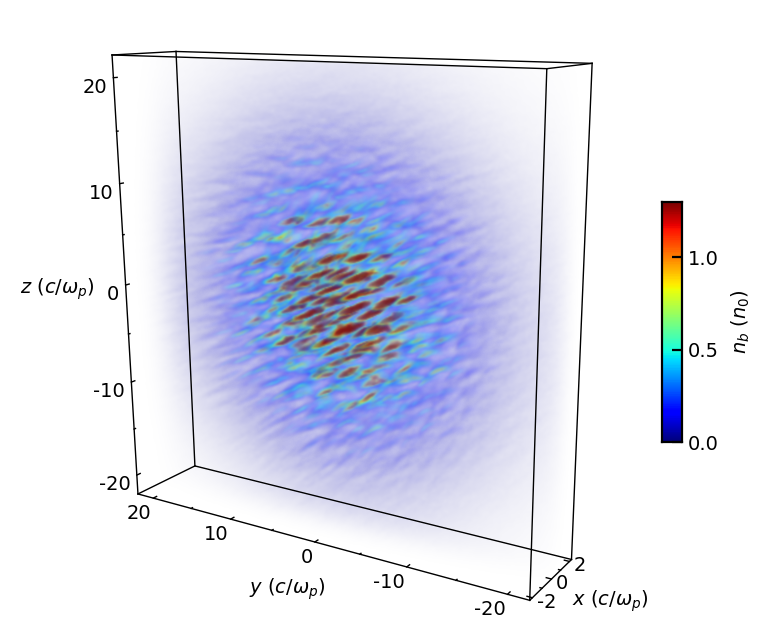

In [236]:
frame = 2
x0 = 500.4*frame-3
plotPathTrace([froot+'MS/DENSITY/beam_electrons/charge-savg'],['charge'],frame,
             rcamera=rcamera,thcamera=thcamera,pixels=pixels,dr=0.1,figsize=(4,4),dpi=200,opacity=1,xslices=slices,
               combineFunc=lambda v:-v[0],vlim=(0,1.3),cmap='jet',fov=fov,
              show=show,axesback=True,axesfront=True,image=True,xlim=[x0-2.2,x0+2.2],ylim=[-22,22],zlim=[-22,22],
               vlabel='$n_b~(n_0)$',offsets=[x0,0,0],scales=[2,1,1],cbarloc='center right')#,save='')

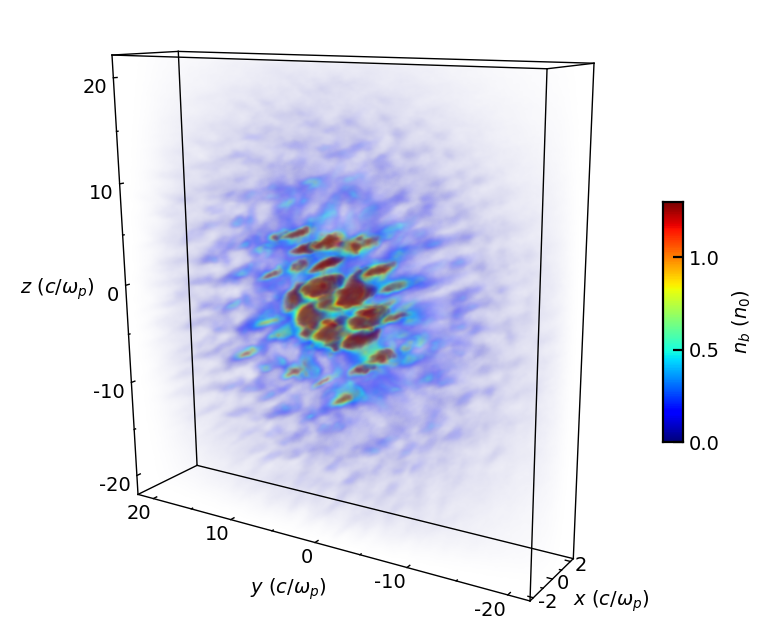

In [250]:
frame = 4
x0 = 500.4*frame-3
plotPathTrace3([froot+'MS/DENSITY/beam_electrons/charge-savg'],['charge'],frame,
             rcamera=rcamera,thcamera=thcamera,pixels=pixels,dr=0.1,figsize=(4,4),dpi=200,opacity=1,xslices=slices,
               combineFunc=lambda v:-v[0],vlim=(0,1.3),cmap='jet',fov=fov,
              show=show,axesback=True,axesfront=True,image=True,xlim=[x0-2.2,x0+2.2],ylim=[-22,22],zlim=[-22,22],
               vlabel='$n_b~(n_0)$',offsets=[x0,0,0],scales=[2,1,1],cbarloc='center right')#,save='')